# Brain Tumor Detection using CNN models

## 1. Problem Statement

Brain tumors are a critical medical concern that affects thousands of individuals worldwide. Early and accurate detection of brain tumors is essential for timely diagnosis and treatment. Medical imaging, such as magnetic resonance imaging (MRI) and computed tomography (CT) scans, provides valuable visual information for diagnosing brain tumors. 

The objective of this project is to develop a CNN-based system for the automatic detection of brain tumors in medical images. The successful implementation of a CNN-based brain tumor detection system will contribute to early and accurate diagnosis, potentially saving lives and improving patient outcomes.

The rest of this report will be structured as follows: we will delve into the dataset and do some exploratory data analysis. We will then follow up with a preferred model architecture and training process which we may either tweak or introduce new models. Finally we will compare these models using evaluation metrics and use the best use case model.

This project can be found on github with this link - https://github.com/pramodhgopal/Brain-Tumor-CNN-Detection

## 2. Data and imports

We will be utilizing the Brain Tumor Dataset from Kaggle - https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset/data. This dataset comes with a few thousand images of mri scans of the human brain which have been classified as either having tumors or being healthy. We also have a metadata.csv which contains information about each of the images such as the format in which it is stored, its shape and its classification. We will associate the images with their respective data and split them into training and validation sets. From there, we will build a few CNN models which will train on the training set and use them to predict the test set. Finally, we will compare the models and identify the best use case model using analysis and various metrics.

Lets start with importing the important libraries which we will be using in this project.

In [1]:
import numpy as np
import pandas as pd
import os
import random
from sklearn.utils import shuffle
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches
from skimage.transform import rotate
from skimage import io
from PIL import Image
import cv2 as cv
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tifffile import imread
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Activation
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

C:\Users\pramo\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


The images are stored locally for me. Let's us see how many images are there in the folders.

In [2]:
img_dir = "./Brain Tumor Data Set/Brain Tumor Data Set/"
for expression in os.listdir(img_dir):
    print(expression, "folder contains", len(os.listdir(img_dir + expression)), 'images')

Brain Tumor folder contains 2513 images
Healthy folder contains 2087 images


In [3]:
meta_df = pd.read_csv('./metadata.csv')
meta_df.head()

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


In [4]:
meta_df.shape

(4600, 6)

Now that we have our image path and dataframe, let's do some exploratory data analysis to get a better understanding of images and the data that we are dealing with. Overall, we have 4600 images in our folders.

## 3. Exploratory Data Analysis

We will start with some simple count plots of the 'class' column from the metadata.csv file.

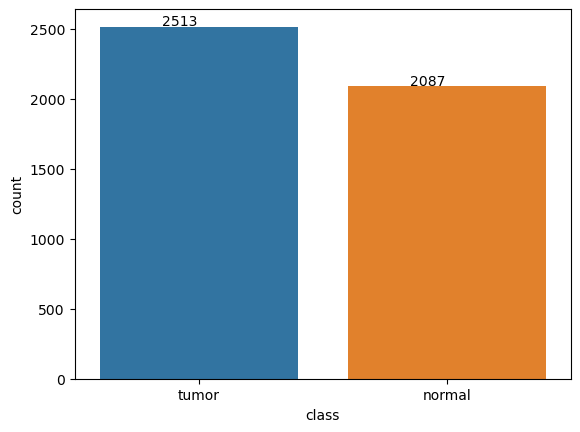

In [5]:
ax = sns.countplot(data = meta_df, x='class')
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+10))

Here we can see the numbers from the count plots matches the number of images in the folders that we printed out before. We have verified that we have the right amount of data.

Let us check the other columns to see if there is anything else we can analyse.

In [6]:
meta_df['format'].value_counts()

JPEG    4496
TIFF      86
PNG       18
Name: format, dtype: int64

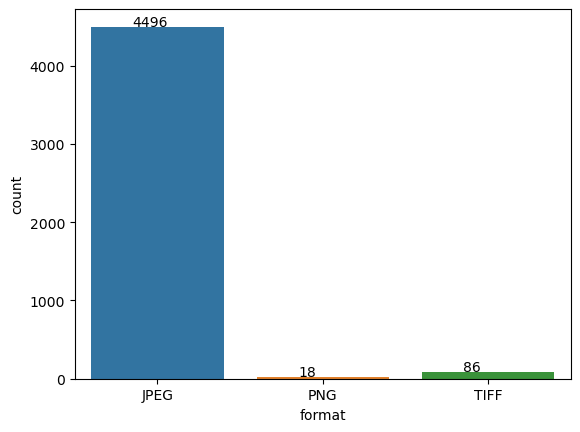

In [7]:
ax = sns.countplot(data = meta_df, x='format')
for p in ax.patches:
   ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+10))

From the plot, we can see that most of the images in the folders are in the JPEG format (4496). There are 18 images that are in the PNG format and 86 that are in the TIFF format. This is good to know that we are not just dealing with a single format of images.

In [8]:
meta_df['shape'].value_counts()

(512, 512, 3)    884
(225, 225, 3)    364
(630, 630, 3)    126
(256, 256, 3)    105
(236, 236, 3)     89
                ... 
(201, 236, 3)      1
(222, 233, 3)      1
(294, 236, 3)      1
(244, 235, 3)      1
(454, 442, 4)      1
Name: shape, Length: 475, dtype: int64

We can also see that the images vary in shape. There are 475 different shapes in which the images are stored. While standardizing image shapes would be ideal for model consistency, I have opted not to undertake this extensive task and simply focus on training the models as is. 

Standardizing the image type, such as converting all images to a single format or color mode, may not be a feasible option either for several reasons. Firstly, it could entail a significant amount of manual or automated effort to convert images to a consistent type. Secondly, some image types, such as medical scans, are specifically saved in formats that preserve essential diagnostic information. Converting these types could lead to a loss of critical data. An additional reason is that the original image type allows the models to handle and learn from the inherent randomness in real-world data, making it more robust for input data.

### 3.1 Splitting and further visualization

Moving forward, we will create a DataFrame that associates image file paths with their corresponding labels, "tumor" and "healthy." It scans the two directories that we mentioned above, one for "Brain Tumor" images and another for "Healthy" images, listing the image files and labeling them accordingly. The resulting dataset is structured as a DataFrame, making it suitable for training and evaluating machine learning models for the classification of brain scans into "tumor" or "healthy" categories. The printed output displays the initial rows of the dataset and the counts of each class label.

We will call this new Dataframe tumor_df.

In [9]:
tumor_dir = img_dir + '/Brain Tumor'
healthy_dir = img_dir + '/Healthy'

# print(tumor_dir)
# print(healthy_dir)

filepaths = []
labels= []
dict_list = [tumor_dir, healthy_dir]
for i, j in enumerate(dict_list):
    flist=os.listdir(j)
    for f in flist:
        fpath=os.path.join(j,f)
        filepaths.append(fpath)
        if i==0:
          labels.append('tumor')
        else:
          labels.append('healthy') 
    
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
tumor_data = pd.concat([Fseries,Lseries], axis=1)
tumor_df = pd.DataFrame(tumor_data)
print(tumor_df.head())
print(tumor_df["labels"].value_counts())

                                           filepaths labels
0  ./Brain Tumor Data Set/Brain Tumor Data Set//B...  tumor
1  ./Brain Tumor Data Set/Brain Tumor Data Set//B...  tumor
2  ./Brain Tumor Data Set/Brain Tumor Data Set//B...  tumor
3  ./Brain Tumor Data Set/Brain Tumor Data Set//B...  tumor
4  ./Brain Tumor Data Set/Brain Tumor Data Set//B...  tumor
tumor      2513
healthy    2087
Name: labels, dtype: int64


Now that we have the tumor_df, we will split the dataset into distinct subsets for training, testing, and validation. The training set will be used to teach the model, the validation set helps optimize it, and the testing set provides the ultimate assessment of the model's generalization to new data.

Once we split the dataframe, we will set up data generators using the ImageDataGenerator class to efficiently process and load image data for deep learning. It configures three generators, train, test, and val, each associated with specific datasets (training, testing, and validation). The generators are connected to the respective dataframes, specifying the file paths and labels for each image.

In [10]:
train_images, test_images = train_test_split(tumor_df, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(tumor_df, test_size=0.2, random_state=42)

print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(3680, 2)
(920, 2)
(920, 2)
(3680, 2)


In [11]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)

train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", 
                                      batch_size=32,
                                      shuffle=False            
                                     )

test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )

val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 3680 validated image filenames belonging to 2 classes.
Found 920 validated image filenames belonging to 2 classes.
Found 920 validated image filenames belonging to 2 classes.


Now that we have split the dataset into its specific sets, let us try to visualize some images from the folder and see if we can identify the tumorous images and the healthy ones. We will be taking a look at the 25 images, each labeled with their class.

In [12]:
def show_brain_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen)
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name,fontsize=16)
        plt.axis('off')
    plt.show()

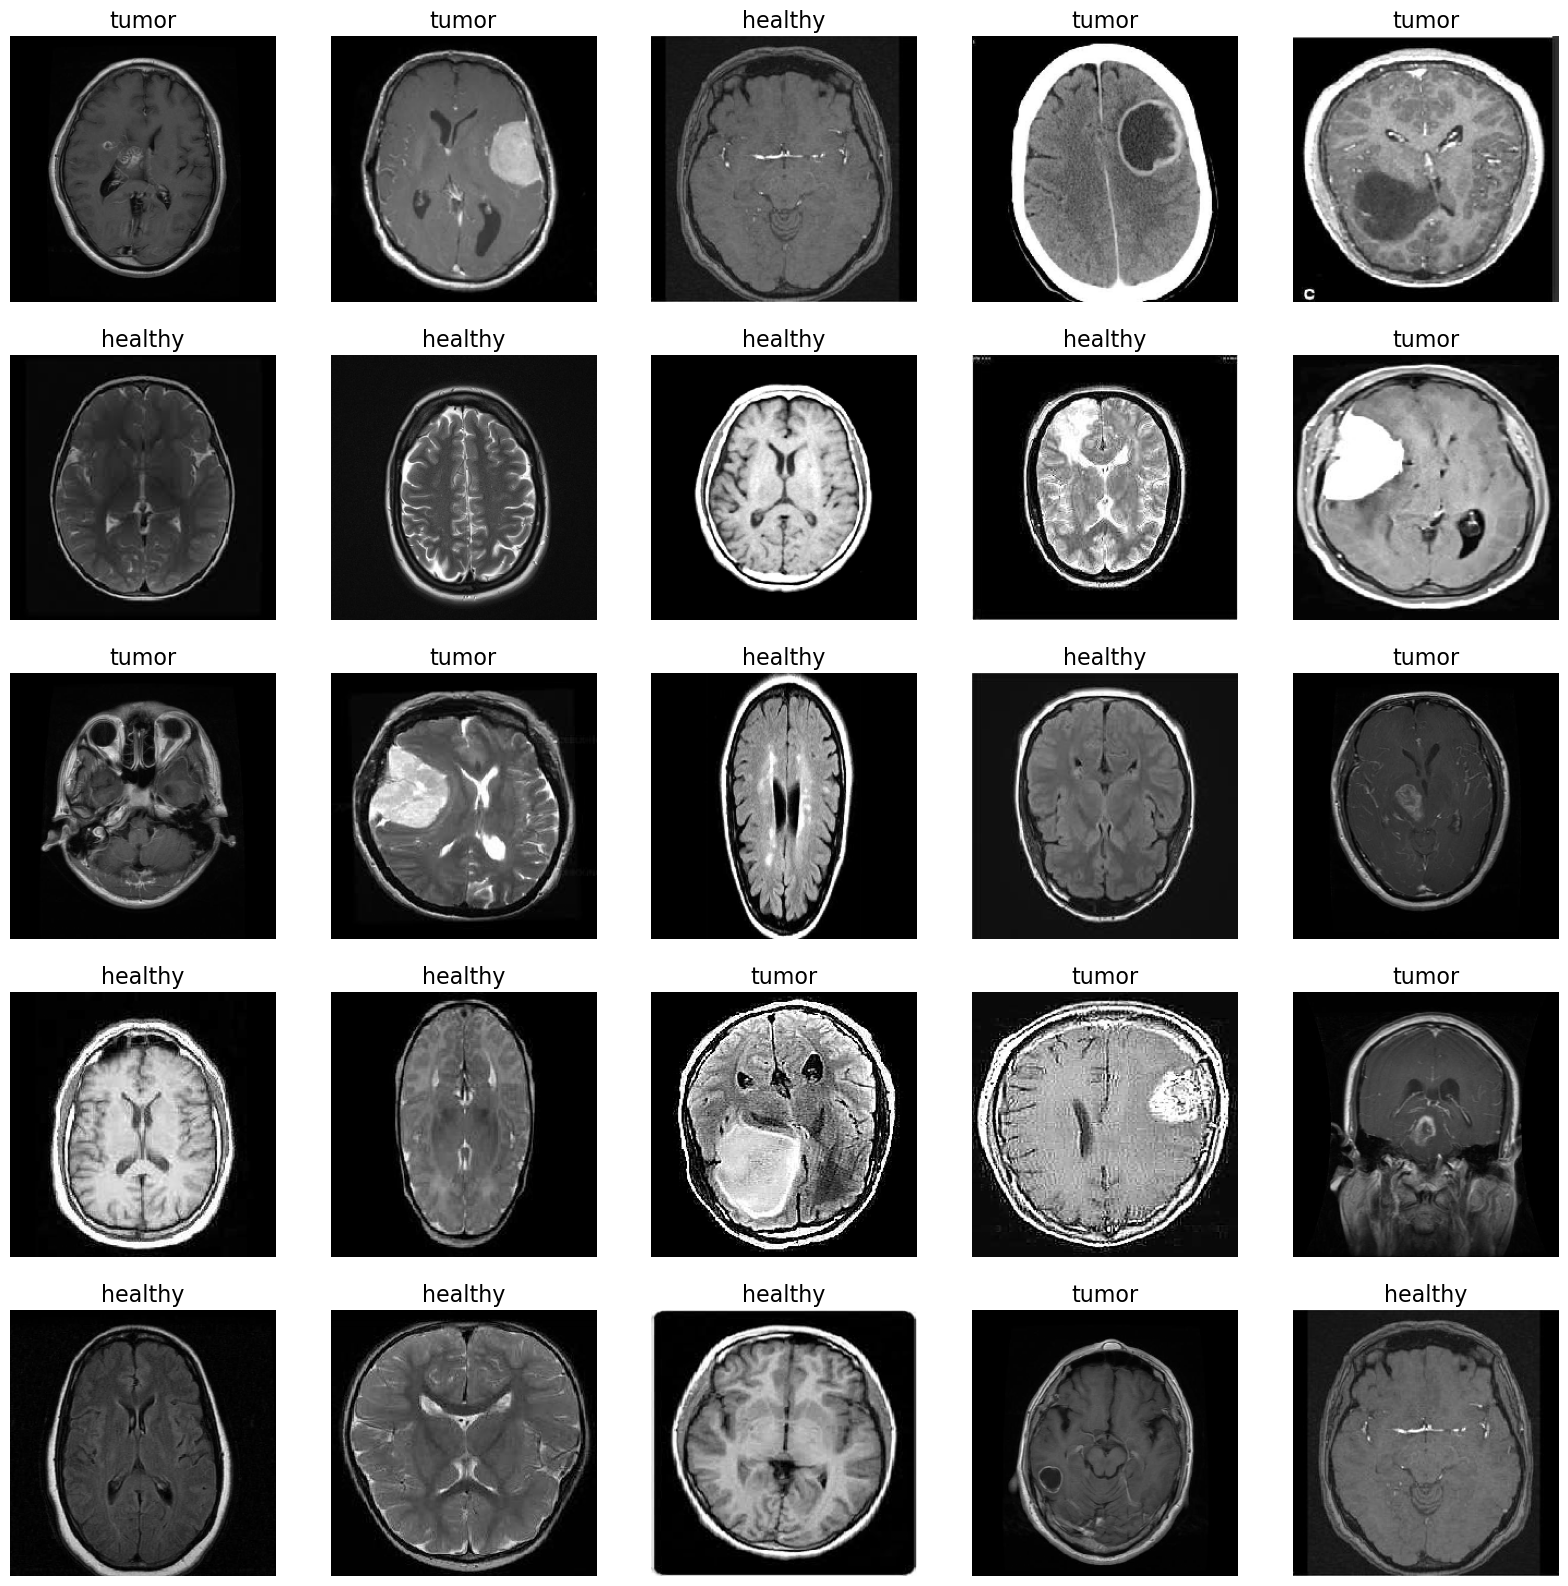

In [13]:
show_brain_images(train)

The 'tumor' labeled image scans exhibit anomalous bright spots within the brain. It's important to note that the dataset includes not only top-down MRI scans but also frontal/back scans, which can make it more challenging to visually identify bright spots. While I have no subject matter expertise on these images, it was still interesting to observe how tumors are depicted in the various image perspectives.

As part of the model development, it's essential to assess how well the model generalizes to varying image perspectives, such as these frontal/back scans, which can be challenging to interpret due to differences in orientation and view. Evaluating the model's performance on side scans provides insights into its versatility and its ability to detect tumors from diverse image sources.

Before we move on to the model architecture, let us confirm the number of tumor and healthy images in the test set. We will be using this to compare how well our different models performed.

In [14]:
tumor_count = 0
healthy_count = 0

# Iterate through the labels in the test dataset
for label in test.classes:
    if label == 0:  
        tumor_count += 1
    elif label == 1: 
        healthy_count += 1

print("Number of Tumor Samples in Test:", tumor_count)
print("Number of Healthy Samples in Test:", healthy_count)

Number of Tumor Samples in Test: 399
Number of Healthy Samples in Test: 521


---

## 4. Models and their Architecture

We will try training three similar CNN models. Once they are trained, we will use them to predict the test set and compare how well they perform against each other. Before I break down the models, I will start out with some helper functions for plotting the model accuracy and model loss per epoch for each model, and a function showcasing the metrics of the particular model.

#### Helper function for all models

In [15]:
def plot_training_history(history):
    # Plot accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy per Epoch')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss per Epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()
    
def evaluate_model(model, test_data):
    # Make predictions
    pred = model.predict(test_data)
    pred = np.argmax(pred, axis=1) #pick class with highest  probability

    labels = (train.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred2 = [labels[k] for k in pred]

    y_test = test_images.labels # set y_test to the expected output
    print(classification_report(y_test, pred2))
    print("Accuracy of the Model:",accuracy_score(y_test, pred2)*100,"%")
    confusion_matrix_array = np.array(confusion_matrix(y_test, pred2))
    print("Confusion matrix:\n", confusion_matrix_array)

The code below checks if a TPU is available for training machine learning models. This code allows you to take advantage of TPUs for accelerated training if they are available, falling back to CPU or GPU training if not.

In [16]:
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

### 4.1 Model 1

The architecture of the first model is structured as follows:

Input -> Convolutional Layer (32 filters, 3x3 kernel, ReLU activation) -> Max-Pooling Layer (2x2 pool) -> Flatten -> Dense (128 units, ReLU activation) -> Dropout (30% dropout) -> Dense (64 units, ReLU activation) -> Output (2 units, sigmoid activation)

This architecture utilizes ReLU activation functions to introduce non-linearity and capture essential features. Dropout is employed to reduce overfitting, and the output layer uses sigmoid activation to produce binary classification results. The model is ready for training, and the evaluation will include accuracy and binary cross-entropy loss metrics to assess its performance. This model will run for 10 epochs.

In [24]:
# Input layer
input_layer = Input(shape=(244, 244, 3))

# Convolutional and pooling layers
conv1 = Conv2D(32, (3, 3), activation="relu")(input_layer)
pool1 = MaxPooling2D((2, 2))(conv1)

# Flatten layer
flatten = Flatten()(pool1)

# Dense layers with dropout
dense1 = Dense(128, activation='relu')(flatten)
dropout1 = Dropout(0.3)(dense1)
dense2 = Dense(64, activation="relu")(dropout1)

# Output layer
output_layer = Dense(2, activation="sigmoid")(dense2)

# Create the model
model1 = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 242, 242, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 121, 121, 32)      0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 468512)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               59969664  
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                           

In [25]:
first_model = model1.fit(train, validation_data= val, epochs=10,verbose=1)

Epoch 1/10
115/115 [==============================] - 54s 463ms/step - loss: 1.4250 - accuracy: 0.7177 - val_loss: 0.3599 - val_accuracy: 0.8576
Epoch 2/10
115/115 [==============================] - 53s 461ms/step - loss: 0.2853 - accuracy: 0.8872 - val_loss: 0.2038 - val_accuracy: 0.9207
Epoch 3/10
115/115 [==============================] - 53s 461ms/step - loss: 0.1699 - accuracy: 0.9380 - val_loss: 0.1531 - val_accuracy: 0.9359
Epoch 4/10
115/115 [==============================] - 53s 460ms/step - loss: 0.1451 - accuracy: 0.9527 - val_loss: 0.2133 - val_accuracy: 0.9293
Epoch 5/10
115/115 [==============================] - 53s 461ms/step - loss: 0.0765 - accuracy: 0.9728 - val_loss: 0.1261 - val_accuracy: 0.9576
Epoch 6/10
115/115 [==============================] - 53s 461ms/step - loss: 0.0530 - accuracy: 0.9840 - val_loss: 0.1868 - val_accuracy: 0.9500
Epoch 7/10
115/115 [==============================] - 53s 462ms/step - loss: 0.0588 - accuracy: 0.9810 - val_loss: 0.1373 - val_ac

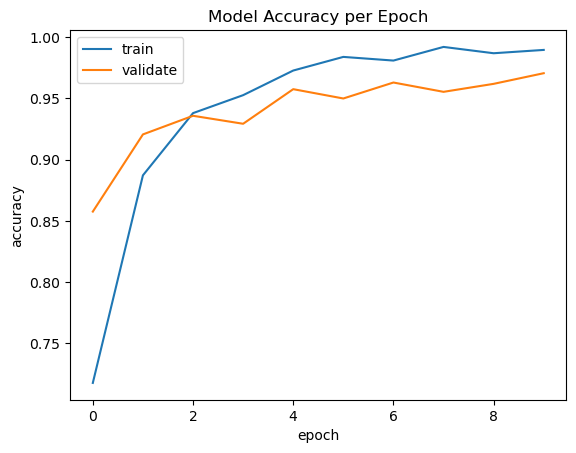

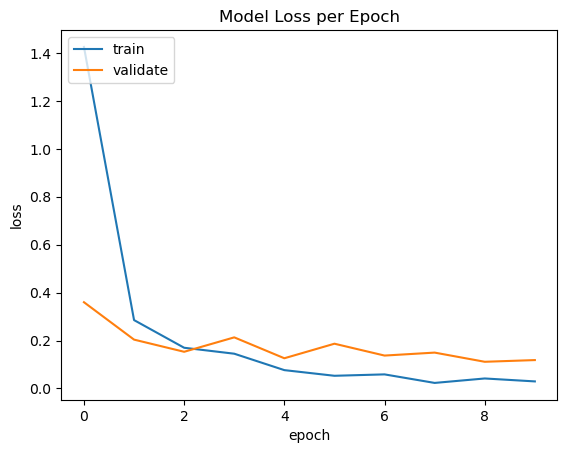

In [26]:
plot_training_history(first_model)

The provided training epochs reveal several notable trends. As the number of training epochs progresses, the model exhibits clear improvements, with decreasing loss and increasing accuracy, both in the training and validation datasets. These trends suggest that the model is learning to make more accurate predictions. Additionally, the close alignment of training and validation accuracy values indicates that overfitting is effectively managed. The model's convergence over the ten epochs implies that it is steadily approaching a solid solution. Furthermore, the continuous improvement in validation accuracy and reduction in validation loss are positive signs, indicating the model's effectiveness in generalizing to unseen data. While the model demonstrates promising progress, there is potential for further training to enhance performance, particularly considering the absence of overfitting signs.

In [27]:
evaluate_model(model1, test)

29/29 [==============================] - 4s 118ms/step
              precision    recall  f1-score   support

     healthy       0.96      0.97      0.97       399
       tumor       0.97      0.97      0.97       521

    accuracy                           0.97       920
   macro avg       0.97      0.97      0.97       920
weighted avg       0.97      0.97      0.97       920

Accuracy of the Model: 97.06521739130434 %
Confusion matrix:
 [[386  13]
 [ 14 507]]


The provided metrics indicate that the model performs exceptionally well in accurately classifying both healthy and tumor samples, even in the presence of a class imbalance. The high precision, recall, and F1-scores, along with a high overall accuracy, suggest that the model is robust and effective for the given task.

The confusion matrix provides a detailed breakdown of the model's predictions. It reveals that out of 399 healthy samples, 386 were correctly classified, and 13 were incorrectly classified as tumors. Out of 521 tumor samples, 507 were correctly classified, and 14 were incorrectly classified as healthy.

### 4.2 Model 2

The architecture of the second model is similar to the first model. The primary differences are in the hyperparameters, such as the number of filters, units in dense layers, and dropout rates, which can affect the model's capacity and performance. 

We increased the number of filters in the convolutional layers. The first dense layer now has 256 units instead of 128 in the previous model.The dropout rate in the dropout layer is increased from 30% to 50%. The activation functions (ReLU) and the use of sigmoid activation in the output layer remain the same and the model is still compiled using the Adam optimizer and categorical cross-entropy loss for binary classification. 

These changes aim to create a slightly different model with fewer units in the dense layers and a lower dropout rate.

In [28]:
ROC_model = tf.keras.metrics.AUC()

model2 = Sequential()

# Convolutional layer
model2.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="valid",
                 input_shape=(244, 244, 3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
model2.add(Flatten())

# Dense layers with dropout
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(rate=0.5))
model2.add(Dense(128, activation="relu"))

# Output layer
model2.add(Dense(2, activation="sigmoid"))

model2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 242, 242, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 121, 121, 64)      0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 937024)            0         
                                                                 
 dense_9 (Dense)             (None, 256)               239878400 
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                      

In [30]:
second_model = model2.fit(train, validation_data= val, epochs=10,verbose=1)

Epoch 1/10
115/115 [==============================] - 154s 1s/step - loss: 0.8789 - accuracy: 0.7446 - val_loss: 0.3535 - val_accuracy: 0.8641
Epoch 2/10
115/115 [==============================] - 154s 1s/step - loss: 0.3729 - accuracy: 0.8660 - val_loss: 0.2745 - val_accuracy: 0.9130
Epoch 3/10
115/115 [==============================] - 154s 1s/step - loss: 0.2112 - accuracy: 0.9207 - val_loss: 0.1413 - val_accuracy: 0.9543
Epoch 4/10
115/115 [==============================] - 154s 1s/step - loss: 0.1119 - accuracy: 0.9639 - val_loss: 0.1197 - val_accuracy: 0.9609
Epoch 5/10
115/115 [==============================] - 154s 1s/step - loss: 0.0894 - accuracy: 0.9728 - val_loss: 0.1148 - val_accuracy: 0.9630
Epoch 6/10
115/115 [==============================] - 154s 1s/step - loss: 0.0720 - accuracy: 0.9793 - val_loss: 0.1261 - val_accuracy: 0.9685
Epoch 7/10
115/115 [==============================] - 153s 1s/step - loss: 0.0487 - accuracy: 0.9859 - val_loss: 0.1206 - val_accuracy: 0.9696

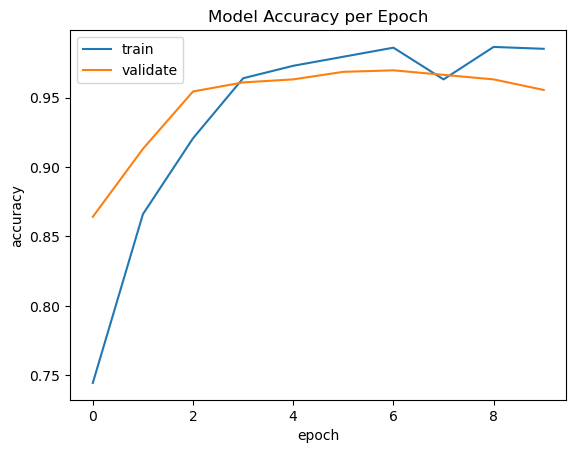

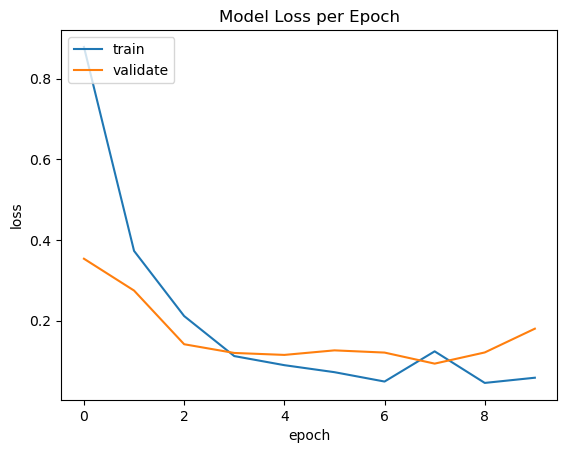

In [31]:
plot_training_history(second_model)

The training results for the ten epochs of the neural network model reveal a progressive pattern of learning and performance enhancement. During this training, both the training and validation losses consistently decrease, showcasing the model's capability to make better predictions as it learns. The training accuracy reaches a high of 98.51%, and the validation accuracy peaks at 95.54% in the final epoch. However, a subtle divergence between training and validation metrics emerges towards the later epochs, suggestive of potential overfitting, where the model may overemphasize the training data at the expense of generalization. Despite this, the final validation accuracy remains respectable.

In [32]:
evaluate_model(model2, test)

29/29 [==============================] - 6s 215ms/step
              precision    recall  f1-score   support

     healthy       0.96      0.94      0.95       399
       tumor       0.95      0.97      0.96       521

    accuracy                           0.96       920
   macro avg       0.96      0.95      0.95       920
weighted avg       0.96      0.96      0.96       920

Accuracy of the Model: 95.54347826086956 %
Confusion matrix:
 [[374  25]
 [ 16 505]]


Similar to the first model, the evaluation results of the model on the test set show strong performance, with some key insights. The model exhibits high accuracy, good precision, recall, and F1-scores. It performs well in classifying both "healthy" and "tumor" samples, with a slightly higher rate of false positives compared to false negatives. The model correctly classified 374 healthy samples and 505 tumor samples. It misclassified 25 healthy samples as tumors) and 16 tumor samples as healthy. 

Comparing the two models so far, Model 1 has a slightly higher accuracy, precision, and recall for the "healthy" class. It correctly classifies healthy samples and tumor samples with a slightly higher accuracy. On the other hand, Model 2 has a slightly higher recall for the "tumor" class. Model 1 seems to have a better balance between precision and recall, which results in a slightly higher overall accuracy. 

### 4.3 Model 3 with early stopping

The third model's architecture is similar to the first two models, it just builds on the complexity. 

Input -> Convolutional Layer (32 filters, 3x3 kernel, ReLU activation) -> Max-Pooling Layer (2x2 pool) -> Convolutional Layer (64 filters, 3x3 kernel, ReLU activation) -> Max-Pooling Layer (2x2 pool) -> Convolutional Layer (128 filters, 3x3 kernel, ReLU activation) -> Max-Pooling Layer (2x2 pool) -> Flatten -> Dense (256 units, ReLU activation) -> Dropout (50% dropout) -> Dense (128 units, ReLU activation) -> Dropout (50% dropout) -> Output (2 units, softmax activation)

It has three convolutional layers with increasing filter counts (32, 64, 128) and uses "same" padding to maintain the spatial dimensions. Each convolutional layer is followed by max-pooling. After the convolutional layers, it flattens the output. It has two dense layers with 256 and 128 units, both with ReLU activation and dropout layers (0.5 dropout rate). The output layer has two units with softmax activation for binary classification.

Comparing model 3 to model 1 and model 2, model 3 has more convolutional layers, a higher number of units in the dense layers, and "same" padding in convolutional layers. This increased complexity may allow it to capture more intricate features in the data but could also be more prone to overfitting. In the case of model 3, early stopping was added to prevent the deep and complex architecture from overfitting the training data.

In [33]:
model3 = Sequential()

# Convolutional and pooling layers
model3.add(Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(244, 244, 3)))
model3.add(MaxPooling2D((2, 2)))

model3.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model3.add(MaxPooling2D((2, 2)))

model3.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model3.add(MaxPooling2D((2, 2)))

# Flattening
model3.add(Flatten())

# Dense layers with dropout
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))

model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))

# Output layer
model3.add(Dense(2, activation="softmax"))  # Softmax for binary classification

# Compile the model
model3.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 244, 244, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 122, 122, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 61, 61, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 30, 30, 128)      

In [34]:
third_model = model3.fit(train, validation_data= val, epochs=10,verbose=1)

Epoch 1/10
115/115 [==============================] - 107s 922ms/step - loss: 0.6128 - accuracy: 0.6842 - val_loss: 0.4386 - val_accuracy: 0.8163
Epoch 2/10
115/115 [==============================] - 105s 909ms/step - loss: 0.3481 - accuracy: 0.8565 - val_loss: 0.2873 - val_accuracy: 0.8707
Epoch 3/10
115/115 [==============================] - 105s 909ms/step - loss: 0.2005 - accuracy: 0.9231 - val_loss: 0.1827 - val_accuracy: 0.9293
Epoch 4/10
115/115 [==============================] - 105s 912ms/step - loss: 0.1169 - accuracy: 0.9541 - val_loss: 0.1627 - val_accuracy: 0.9522
Epoch 5/10
115/115 [==============================] - 105s 909ms/step - loss: 0.0799 - accuracy: 0.9712 - val_loss: 0.1151 - val_accuracy: 0.9652
Epoch 6/10
115/115 [==============================] - 106s 921ms/step - loss: 0.0456 - accuracy: 0.9861 - val_loss: 0.1187 - val_accuracy: 0.9620
Epoch 7/10
115/115 [==============================] - 105s 911ms/step - loss: 0.0528 - accuracy: 0.9815 - val_loss: 0.1125 -

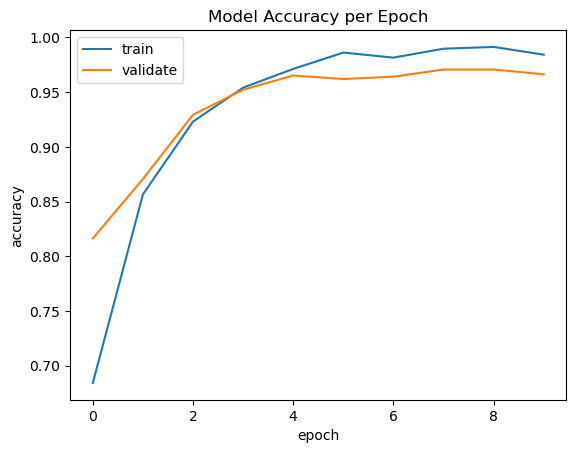

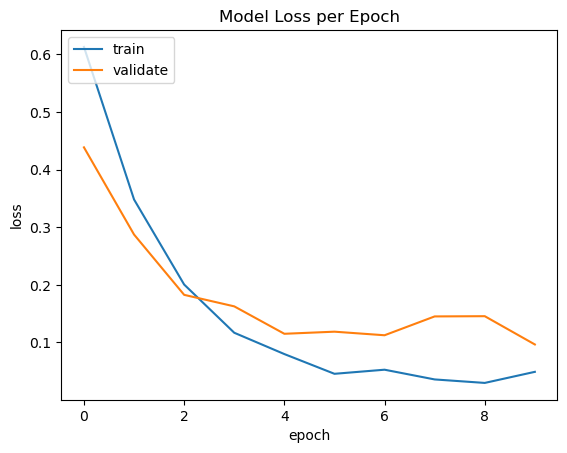

In [35]:
plot_training_history(third_model)

From the training history and plots, we can see that the training loss consistently decreases from epoch to epoch. This indicates that the model is learning to fit the training data better, which is a positive sign. The model seems to be learning effectively from the training data and generalizing well to the validation set. These results suggest that the training process is progressing as expected.

In [36]:
evaluate_model(model3, test)

29/29 [==============================] - 6s 208ms/step
              precision    recall  f1-score   support

     healthy       0.94      0.98      0.96       399
       tumor       0.99      0.95      0.97       521

    accuracy                           0.97       920
   macro avg       0.96      0.97      0.97       920
weighted avg       0.97      0.97      0.97       920

Accuracy of the Model: 96.6304347826087 %
Confusion matrix:
 [[393   6]
 [ 25 496]]


The model achieves an accuracy of approximately 96.63%. This indicates that it correctly classified 96.63% of the test set samples. The precision and recall values for both the "healthy" and "tumor" classes are quite high. In both cases, the values are close to 1, indicating that the model is making accurate and comprehensive predictions for both classes. The model correctly classified 393 healthy samples and 495 tumor samples. It only misclassified 6 healthy samples as tumors, but 25 tumor samples as healthy. 

## 5. Comparing models

Let's compare the models' metrics and confusion matrixes side-by-side.

    Metrics

| Model       | Accuracy | Precision (Healthy) | Recall (Healthy) | F1-score (Healthy) | Precision (Tumor) | Recall (Tumor) | F1-score (Tumor) |
|-------------|----------|----------------------|------------------|---------------------|-------------------|---------------|------------------|
| Model 1     | 97.07%   | 0.96                 | 0.97             | 0.97                | 0.97              | 0.97          | 0.97             |
| Model 2     | 95.54%   | 0.96                 | 0.94             | 0.95                | 0.95              | 0.97          | 0.96             |
| Model 3     | 96.63%   | 0.94                 | 0.98             | 0.96                | 0.99              | 0.95          | 0.97             |

    Confusion Matrices

| Model 1  | Model 2  | Model 3  |
|--------------------------|--------------------------|--------------------------|
| [386,  13]              | [374,  25]              | [393,   6]              |
| [ 14, 507]              | [ 16, 505]              | [ 25, 496]              |


**Accuracy**:
    Model 1 has the highest accuracy at 97.07%, while Model 2 has the lowest at 95.54%.

**Precision (Healthy)**:
    Model 1 and Model 2 have the same precision for healthy cases (0.96), indicating that they have a similar ability to correctly identify healthy cases. Model 3 has a lower precision for healthy cases at 0.94.

**Recall (Healthy)**:
    Model 3 has the highest recall for healthy cases at 0.98, meaning it effectively captures a large portion of actual healthy cases. Model 1 is close behind at 0.97 and Model 2 has the lowest value at 0.94.

**F1-score (Healthy)**:
    F1-score combines precision and recall, and Model 1 has the highest F1-score for healthy cases at 0.97.
    Model 3 follows with an F1-score of 0.96, and Model 2 has the lowest F1-score for healthy cases at 0.95.

**Precision (Tumor)**:
    Model 3 has the highest precision for tumor cases at 0.99, indicating it is good at correctly identifying tumor cases.
    Model 1 and Model 2 have precision values of 0.97 and 0.95 respectively, showing they also perform well but slightly lower than Model 3.

**Recall (Tumor)**:
    Model 2 and Model 1 has the highest recall for tumor cases at 0.97, which means it effectively captures actual tumor cases. Model 3 has a lower recall for tumor cases at 0.95.

**F1-score (Tumor)**:
    Model 1 and Model 3 have an equal F1-score for tumor cases at 0.97, indicating balanced performance.
    Model 2 is close with 0.96.

From the confusion matrices, we observe that Model 3 stands out with the highest number of true positives in classifying healthy cases. This suggests that Model 3 excels in accurately identifying and classifying healthy cases. In contrast, Models 1 and 2 exhibit slightly lower performance in this specific aspect. 
Overall, Model 1 and Model 3 achieve the highest overall accuracy at 97.07% and 96.63%, respectively. Model 2, while still performing well with an accuracy of 95.54%, demonstrates a marginally lower F1-score in classifying healthy cases compared to Models 1 and 3. 

## 6. Conclusion

In conclusion, among the three image classification models scrutinized in our analysis, Model 1 emerges as the best selection for a number of compelling reasons. First and foremost, it delivers the highest accuracy, reaching an impressive 97.07%, signifying its competence in correctly categorizing both healthy and tumor cases. Furthermore, Model 1 strikes an appealing balance between precision and recall for both healthy and tumor categories, with precision and recall values of 0.96 and 0.97, respectively. These statistics underscore its accuracy in identifying true positives while limiting the number of false positives and false negatives. Model 1's consistent F1-scores of 0.97 across both classes reinforce its robustness. Additionally, its confusion matrix illustrates a remarkable 386 true positives for healthy cases and 507 true positives for tumor cases, reaffirming its capability in the precise classification of patients. With a strong overall performance, Model 1 solidifies its position as the most reliable and stable solution for binary image classification tasks, making it the ideal choice in scenarios demanding precision and reliability in the identification of medical images.

Github link - https://github.com/pramodhgopal/Brain-Tumor-CNN-Detection

**References** - 
    
    Brain Tumor Dataset - https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset/data
    
    Image classification - https://keras.io/examples/vision/image_classification_from_scratch/
    
    Different Types of CNN Architectures Explained: Examples - https://vitalflux.com/different-types-of-cnn-architectures-explained-examples/